In [2]:
%matplotlib inline

import math
import sys
import os
import numpy as np
from io import StringIO
import matplotlib.pyplot as plt
import pandas as pd
import ibis
# from pyspark import SparkContext
# from pyspark.sql import SparkSession
# impala_client.close()
# hdfs_client.close()
ibis.options.sql.default_limit = None
impala_client = ibis.impala.connect(host='192.168.23.236', port=21050, user='app_bi')
hdfs_client = ibis.hdfs_connect(host='192.168.23.223', port=50070,user='app_bi').client

# spark = SparkSession.builder \
#    .master("yarn") \
#    .appName("spark_test") \
#       .config("spark.executor.instances", 20) \
#        .config("spark.executor.cores", 1) \
#        .config("spark.executor.memory", '4G') \
#        .config("spark.driver.memory", '4G') \
#    .enableHiveSupport() \
#    .getOrCreate()

# 班型信息分析

## 班型下课次数

In [3]:
param={"year":2018,"city_name":"杭州","grade_name":"初中一年级","subject_name":"数学",'term_name':"春季班","level_name":""}


In [4]:
_sql="""
        select
             cl.cl_lev_name as 班型,
             count(distinct cl.cl_course_name) as 课次数量
        
        from dimdb.dim_course_level cl
        where
            cl.cl_year='%(year)s'
            and cl.cl_city_name = '%(city_name)s'
            and cl.cl_grd_name='%(grade_name)s'
            and cl.cl_term_name='%(term_name)s'
            and cl.cl_subj_name='%(subject_name)s'
            and cl.cl_is_delete='否'
        group by
            cl.cl_lev_name
""" % param
df_level = impala_client.sql(_sql).execute()
df_level.sort_values(['班型'])

,班型,课次数量
4,基础班,15
3,实验班,15
2,尖子班,15
1,尖子班(双师),15
0,提高班,15
5,提高班(双师),15


## 课次信息

In [5]:
_sql="""
        select
             c.c_lev_name as 班型,
             c.c_sortorder as 课次序号 ,  --课次序号
             c.c_name as 课次名称,
             cl.cl_num as 课次关卡数量, -- 当前课次关卡数量
             lq.question_num as 题目数量,
             cs.stundent_count as 学生数量,
             cs.pass_count as 通关人数,
             cs.pass_count/cs.stundent_count as 通关比例
             
        from dimdb.dim_course c --课次表
        left join 
            (select 
                cl_course_id,
                cl_course_name,
                count(distinct cl_name) as cl_num --当前课次关卡数量
            from dimdb.dim_course_level
            where
                 cl_year='%(year)s'
                and cl_city_name = '%(city_name)s'
                and cl_grd_name='%(grade_name)s'
                and cl_term_name='%(term_name)s'
                and cl_subj_name='%(subject_name)s'
                and cl_is_delete='否'
               
                and cl_is_game='否'
            group by cl_course_id,cl_course_name 
            ) cl on cl.cl_course_id = c.pk_course  --课次关卡表
        
        left join 
        
            ( select 
                cl_course_id, --课次id
                count(distinct lq_origin_id) as question_num --当前课次题目总数
            from dimdb.dim_level_question 
            join dimdb.dim_course_level on dim_level_question.lq_cl_id=dim_course_level.pk_courselevel 
            where
                lq_city_name='%(city_name)s'
                
                and  lq_library_id='5'
            group by cl_course_id
            ) lq  on lq.cl_course_id=c.pk_course  -- 课次关卡题目表
         
        
        left join
        
            (select 
                fk_course,
                
                --cs.total_qst_num, --当前课次当前学生作答总数
                --cs.right_qst_num, --当前课次当前学生正确题目数量
                count(distinct fk_student) as stundent_count, -- 学生数量
                sum(cuc_clearance_num) as pass_count -- 通关学生数量
            from dwdb.dws_stdy_ips_stu_cuc_status
            where 
                 fk_year='%(year)s'
                and city_name='%(city_name)s'
                and grd_name='%(grade_name)s'
                and term_name='%(term_name)s'
                and subj_name='%(subject_name)s'
            group by fk_course
            ) cs on cs.fk_course = c.pk_course --学生课次答题状态表
        
        where 
            c_year='%(year)s'
            and city_name='%(city_name)s'
            and c_grd_name='%(grade_name)s'
            and c_term_name='%(term_name)s'
            and c_subj_name='%(subject_name)s'
    
""" % param
df_cuc = impala_client.sql(_sql).execute()


### 已开课课次

In [6]:
df_cuc.loc[df_cuc['学生数量']>0].sort_values(['班型','课次序号'])

,班型,课次序号,课次名称,课次关卡数量,题目数量,学生数量,通关人数,通关比例
37,基础班,1,转角训练,5.0,17.0,294.0,283.0,0.962585
64,基础班,2,解特殊二元一次方程组,5.0,16.0,288.0,268.0,0.930556
40,基础班,3,整式运算拓展,5.0,16.0,287.0,261.0,0.909408
72,基础班,4,复杂乘法公式与配方法,5.0,17.0,288.0,253.0,0.878472
6,基础班,5,乘除运算之整体应用,5.0,16.0,278.0,243.0,0.874101
26,基础班,6,期中复习,5.0,16.0,283.0,210.0,0.742049
28,基础班,7,因式分解的两大常用方法,5.0,17.0,277.0,190.0,0.685921
25,基础班,8,因式分解的高端方法及应用,5.0,18.0,250.0,19.0,0.076000
52,基础班,9,分式的概念及性质,5.0,17.0,70.0,0.0,0.000000
0,实验班,1,乘法公式的综合应用,5.0,19.0,158.0,143.0,0.905063


结论：

1. 杭州，提高班和尖子班学生基数和通过率都很高，适合作为试验点。
2. 未开课课次，没有配置题目


### 未开课课次

In [7]:
df_cuc.loc[ pd.isnull(df_cuc['学生数量'])].sort_values(['班型','课次序号'])

,班型,课次序号,课次名称,课次关卡数量,题目数量,学生数量,通关人数,通关比例
90,基础班,10,分式混合运算及分离常数,5.0,NaN,NaN,NaN,NaN
24,基础班,11,分式方程,5.0,NaN,NaN,NaN,NaN
30,基础班,12,三角形初步,5.0,NaN,NaN,NaN,NaN
61,基础班,13,三角形的基本模型,5.0,NaN,NaN,NaN,NaN
46,基础班,14,期末反馈,5.0,NaN,NaN,NaN,NaN
19,基础班,15,考前突破,5.0,NaN,NaN,NaN,NaN
45,实验班,2,1,NaN,NaN,NaN,NaN,NaN
79,实验班,10,三角形基本模型,5.0,NaN,NaN,NaN,NaN
33,实验班,11,全等三角形的认识,5.0,NaN,NaN,NaN,NaN
22,实验班,12,全等三角形的基本模型,5.0,NaN,NaN,NaN,NaN



# 正确率分析

## 课次正确率分布

In [126]:

#histgram(df_temp,column='答题总数')
def bar(df_target,column):
    data=df_target[column].value_counts().sort_index()
    data.plot(kind='bar')
    plt.xlabel(column)  #设置X轴Y轴名称    
    plt.ylabel("人数")    
    plt.title("%s分布（总人次%d）"%(column,data.sum())) 
    
    for index,value in data.iteritems():  
        
        #plt.text(a+0.05, b+4, '%.0f' % b, ha='center', va= 'bottom',fontsize=11)
        plt.text(index-data.index[0], value+0.05, '%.2f%%' % (100.0*value/data.sum()), ha='center', va= 'bottom',fontsize=11)


        

def histgram(df_target,column='正确率'):
    #df_ans_target=df_ans[df_ans['班型']==level_name]
    #if cuc_id is not None:
    #    df_ans_target=df_ans_target[df_ans_target['课次序号']==cuc_id]
    df_target[column].plot(kind='hist',stacked=True)
    num,bins=np.histogram(df_target['正确率'].values)
    plt.xlabel(column)  #设置X轴Y轴名称    
    plt.ylabel("人数")    
    plt.title("%s分布（总人次%d）"%(column,num.sum())) 
    for a,b in zip(bins,num):    
        #plt.text(a+0.05, b+4, '%.0f' % b, ha='center', va= 'bottom',fontsize=11)
        plt.text(a+0.05, b+0.05, '%.2f%%' % (100.0*b/num.sum()), ha='center', va= 'bottom',fontsize=11)
        
        


In [112]:
_sql="""
        select
            
            level_name as 班型,
            -- fk_course,
            c_sortorder as 课次序号,
            --fk_student,
            stu_name as 学生姓名,
            count(fk_question) as 答题总数, --答题数量
            sum(answer) as 正确数量,
            sum(answer)/count(fk_question) as 正确率,
            sum(answer*difficulty) as score,
            sum(answer*difficulty)/sum(answer) as 平均难度
        from
            (select 
                lev_name as level_name,
                fk_course,
                c_sortorder,
                fk_student,stu_name,
                fk_question,
                
                case when asw_first_status='错误' then 0 else 1  end   answer,
                
--                case when difficulty='很容易' then 1
--                when difficulty='容易' then  2
--                when difficulty='正常' then 3
--                when difficulty='困难' then 4
--                when difficulty='艰难' then 5
--                 end difficulty
                difficulty_id as difficulty

            from dwdb.dwd_stdy_ips_level_answ
           -- join dimdb.dim_level_question lq on lq.fk_question=sa.fk_question and sa.fk_courselevel=lq.lq_cl_id
            where
                 fk_year='%(year)s'
                and city_name = '%(city_name)s'
                and grd_name='%(grade_name)s'
                and term_name='%(term_name)s'
                and subj_name='%(subject_name)s'
                and is_deleted='否'
            --group by lev_name,fk_course,c_sortorder,fk_student,stu_name,
            ) sa
            
        group by
            level_name,fk_course,c_sortorder,fk_student,stu_name
""" %param

df_ans_cuc = impala_client.sql(_sql).execute()
df_ans_cuc_jianzi=df_ans_cuc[df_ans_cuc['班型']=='尖子班']
df_ans_cuc_jianzi.head(10)

,班型,课次序号,学生姓名,答题总数,正确数量,正确率,score,平均难度
0,尖子班,6,杨子轩3,17,15,0.882353,39,2.600000
8,尖子班,4,陈睿7,18,13,0.722222,32,2.461538
9,尖子班,4,钟政烨,18,15,0.833333,36,2.400000
11,尖子班,6,沈轩宇2,17,14,0.823529,35,2.500000
18,尖子班,6,翁远,17,6,0.352941,15,2.500000
22,尖子班,4,谢铭浩,18,15,0.833333,36,2.400000
26,尖子班,4,张育瑞,18,17,0.944444,40,2.352941
27,尖子班,6,刘亦好,17,12,0.705882,31,2.583333
31,尖子班,8,尤家祺,6,5,0.833333,12,2.400000
32,尖子班,9,马仁杰,3,1,0.333333,2,2.000000


### 答题总数分布


**答题总数：** 一个学生在一节课次下答题数量

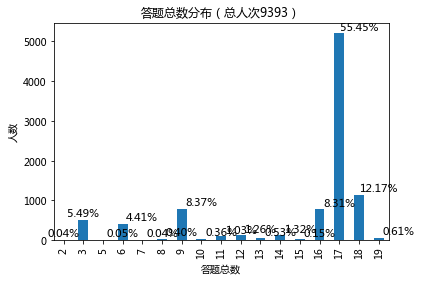

In [127]:
# 尖子班下，所有课次 ，学生每个课次的答题数量分布
bar(df_ans_cuc.loc[df_ans['班型']=='尖子班'],column='答题总数')

### 答题正确率分布


**答题正确率：** 一个学生在一节课次下答题正确率

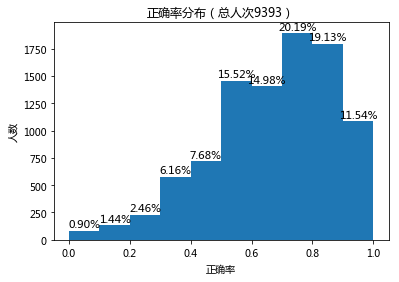

In [118]:
# 尖子班下，所有课次 的学生每个课次答题正确率分布
histgram(df_ans_cuc.loc[df_ans['班型']=='尖子班'],column='正确率')

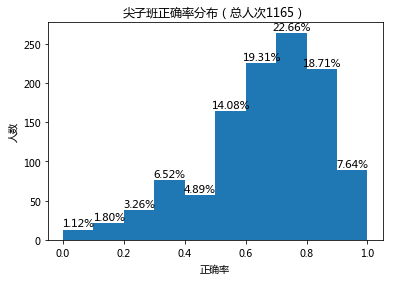

In [59]:
# 尖子班下，课次1 的学生答题正确率分布
histgram(df_ans.loc[(df_ans['班型']=='尖子班') & (df_ans['课次序号']==1)],column='正确率')

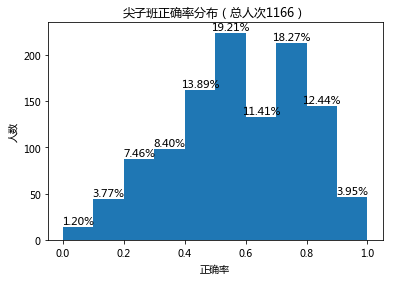

In [60]:
# 尖子班下，课次2 的学生答题正确率分布
histgram(df_ans_cuc.loc[(df_ans['班型']=='尖子班') & (df_ans['课次序号']==2)])

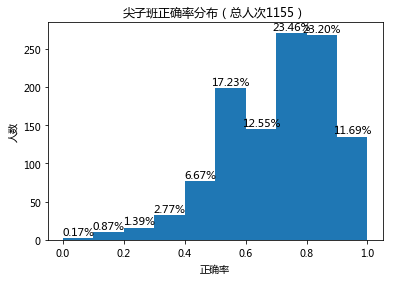

In [61]:
# 尖子班下，课次3 的学生答题正确率分布
histgram(df_ans_cuc.loc[(df_ans['班型']=='尖子班') & (df_ans['课次序号']==3)])

## 知识点正确率分布

In [115]:
_sql="""
        select
            
            level_name as 班型,
            -- fk_course,
            c_sortorder as 课次序号,
            course_name as 课次名称,
            knlg_name as 知识点,
            --fk_student,
            stu_name as 学生姓名,
            count(fk_question) as 答题总数, --答题数量
            sum(answer) as 正确数量,
            sum(answer)/count(fk_question) as 正确率,
            sum(answer*difficulty) as score,
            sum(answer*difficulty)/sum(answer) as 平均难度
        from
            (select 
                lev_name as level_name,
                fk_course,
                course_name,--IPS课次名称
                c_sortorder,
                fk_student,stu_name,
                fk_question,
                fk_knowledge,
                knlg_name,
                
                case when asw_first_status='错误' then 0 else 1  end   answer,
                
--                case when difficulty='很容易' then 1
--                when difficulty='容易' then  2
--                when difficulty='正常' then 3
--                when difficulty='困难' then 4
--                when difficulty='艰难' then 5
--                 end difficulty
                difficulty_id as difficulty

            from dwdb.dwd_stdy_ips_level_answ
           -- join dimdb.dim_level_question lq on lq.fk_question=sa.fk_question and sa.fk_courselevel=lq.lq_cl_id
            where
                 fk_year='%(year)s'
                and city_name = '%(city_name)s'
                and grd_name='%(grade_name)s'
                and term_name='%(term_name)s'
                and subj_name='%(subject_name)s'
                and is_deleted='否'
            --group by lev_name,fk_course,c_sortorder,fk_student,stu_name,
            ) sa
            
        group by
            level_name,fk_course,c_sortorder,course_name,fk_student,stu_name,fk_knowledge,knlg_name
""" %param

df_ans_knlg = impala_client.sql(_sql).execute()


In [116]:
df_ans_knlg[df_ans_knlg['班型']=='尖子班'].sort_values('知识点')

,班型,课次序号,课次名称,知识点,学生姓名,答题总数,正确数量,正确率,score,平均难度
126262,尖子班,3,乘除运算之整体应用,乘方的定义,吕祎然,1,1,1.0,3,3.0
235313,尖子班,3,乘除运算之整体应用,乘方的定义,汤墨非,1,1,1.0,3,3.0
248142,尖子班,3,乘除运算之整体应用,乘方的定义,卢静宜,1,1,1.0,3,3.0
67518,尖子班,3,乘除运算之整体应用,乘方的定义,吴悠3,1,1,1.0,3,3.0
25700,尖子班,3,乘除运算之整体应用,乘方的定义,刘畅,1,1,1.0,3,3.0
9573,尖子班,3,乘除运算之整体应用,乘方的定义,汪煜枫,1,1,1.0,3,3.0
48313,尖子班,3,乘除运算之整体应用,乘方的定义,周曾译清,1,1,1.0,3,3.0
235302,尖子班,3,乘除运算之整体应用,乘方的定义,沈一帆,1,1,1.0,3,3.0
182376,尖子班,3,乘除运算之整体应用,乘方的定义,雒一凡,1,1,1.0,3,3.0
207501,尖子班,3,乘除运算之整体应用,乘方的定义,张轩昊,1,1,1.0,3,3.0


### 知识点答题总数分布

**知识点答题总数：** 一个学生在一节课次一个知识点下答题数量


**所有知识点答题数量分布**

一个班型下，所有课次，所有知识点下，学生答题总数分布

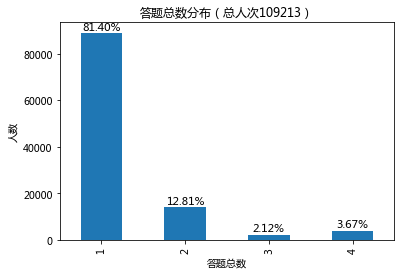

In [128]:
# 尖子班下，所有知识点 的学生知识点下答题数量分布
df_temp=df_ans_knlg.loc[(df_ans_knlg['班型']=='尖子班')]
bar(df_temp,column='答题总数')

**某个知识点答题数量分布**


一个班型下，所有课次，某个知识点下，学生答题总数分布

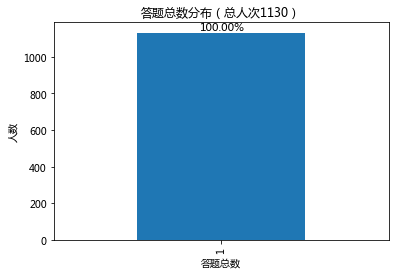

In [108]:
# 尖子班下，某个知识 的学生知识点下答题数量分布
df_temp=df_ans_knlg.loc[(df_ans_knlg['班型']=='尖子班')&(df_ans_knlg['知识点']=='乘方的定义')]
bar(df_temp,column='答题总数')


### 知识点正确率分布


**知识点答题正确率：** 一个学生在一节课次一个知识点下答题正确率

**所有知识点正确率分布**

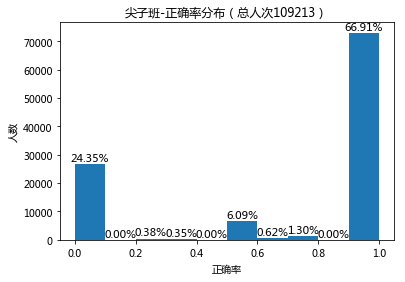

In [109]:
# 尖子班下，所有知识点 的学生知识点下正确率分布
df_temp=df_ans_knlg.loc[(df_ans_knlg['班型']=='尖子班')]
histgram(df_temp,column='正确率')


**某个知识点正确率分布**

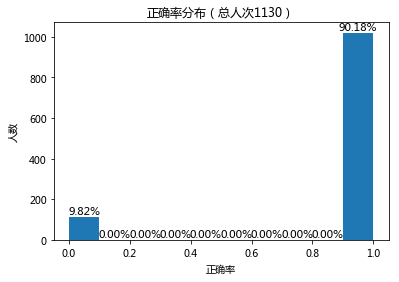

In [129]:
# 尖子班下，某个知识点 的学生知识点下正确率分布
df_temp=df_ans_knlg.loc[(df_ans_knlg['班型']=='尖子班')&(df_ans_knlg['知识点']=='乘方的定义')]
histgram(df_temp,column='正确率')


# 结论

1. 一个知识点下，多数只有一题（**还有没有题目的知识点，无法在数据中体现**），诊断一个学生在一个知识点下的能力基本不可行


# 数据写入excel

详情请去excel文件查看

1. 正确率相同得分未必一样

In [130]:
# 把数据写入到exlce

import sys
reload(sys)
sys.setdefaultencoding('utf-8')
file_name='%(year)s_%(city_name)s_%(grade_name)s_%(subject_name)s_正确率分析.xlsx'%param
writer = pd.ExcelWriter(file_name)
df_level.to_excel(writer,'班型信息',encoding="UTF-8")
df_cuc.to_excel(writer,'课次信息',encoding="UTF-8")
df_ans_cuc.to_excel(writer,'学生课次正确率',encoding="UTF-8")
df_ans_knlg.to_excel(writer,'学生知识点正确率',encoding="UTF-8")
writer.save()

#df_ans.to_excel(,
#                encoding="UTF-8",engine='io.excel.xlsx.writer')



